In [ ]:
# 1. Cài đặt thư viện ultralytics (chứa YOLOv8)
!pip install ultralytics

# 2. Kiểm tra GPU đã nhận chưa
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
!nvidia-smi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.7 MB/s eta 0:00:00
GPU Available: True
Fri Feb  6 15:18:30 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Tạo thư mục chứa dữ liệu
!mkdir -p /content/datasets/weapon

# Giải nén (Thay 'ten_file_cua_ban.zip' cho đúng)
# Giả sử file zip nằm trong thư mục Weapon_Dataset trên Drive
!unzip -q "/content/drive/MyDrive/Weapondataset/archive_2.zip" -d "/content/datasets/weapon"

print("Đã giải nén xong!")

Đã giải nén xong!


In [ ]:
# Xem danh sách các file trong thư mục vừa giải nén
!ls -R /content/datasets/weapon | head -n 20

/content/datasets/weapon:
metadata.csv
test
weapon_detection

/content/datasets/weapon/test:
test

/content/datasets/weapon/test/test:
army.jpg
giphy.gif
mafia-mafia-game.gif
terrorists2.jpg
terrorists.jpg
weapons2.jpg
weaponsgta5.gif
weapons.jpg

/content/datasets/weapon/weapon_detection:
train


In [ ]:
import pandas as pd
import os

train_path = "/content/datasets/weapon/weapon_detection/train"

print(f" '{train_path}' ")
if os.path.exists(train_path):
    print(os.listdir(train_path)[:10])
else:
    print("Không tìm thấy đường dẫn train!")

print("")
csv_path = "/content/datasets/weapon/metadata.csv"
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(df.head())
else:
    print("Không tìm thấy file CSV!")

--- KIỂM TRA 10 FILE TRONG '/content/datasets/weapon/weapon_detection/train' ---
['images', 'labels']

--- KIỂM TRA 5 DÒNG ĐẦU FILE METADATA.CSV ---
                  imagefile                labelfile  target  train_id
0   Automatic Rifle_10.jpeg   Automatic Rifle_10.txt       0         1
1  Automatic Rifle_100.jpeg  Automatic Rifle_100.txt       0         1
2   Automatic Rifle_11.jpeg   Automatic Rifle_11.txt       0         1
3   Automatic Rifle_12.jpeg   Automatic Rifle_12.txt       0         1
4   Automatic Rifle_13.jpeg   Automatic Rifle_13.txt       0         0


In [ ]:
import os
import shutil
import random
import yaml
from ultralytics import YOLO

base_dir = "/content/datasets/weapon/weapon_detection"
train_img_dir = os.path.join(base_dir, "train/images")
train_lbl_dir = os.path.join(base_dir, "train/labels")

# Tạo thư mục valid
val_img_dir = os.path.join(base_dir, "valid/images")
val_lbl_dir = os.path.join(base_dir, "valid/labels")
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# Lấy danh sách tất cả file ảnh
image_files = [f for f in os.listdir(train_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
random.seed(42) # Để kết quả chia giống nhau mỗi lần chạy
random.shuffle(image_files)

# Tính số lượng file cần chuyển sang valid (20%)
num_val = int(len(image_files) * 0.2)
val_files = image_files[:num_val]

print(f"Tổng số ảnh: {len(image_files)}")
print(f"Đang di chuyển {num_val} ảnh sang thư mục Valid để kiểm tra model...")

count = 0
for img_file in val_files:
    # Xác định tên file nhãn tương ứng (thay đuôi ảnh bằng .txt)
    base_name = os.path.splitext(img_file)[0]
    txt_file = base_name + ".txt"

    # Đường dẫn nguồn
    src_img = os.path.join(train_img_dir, img_file)
    src_lbl = os.path.join(train_lbl_dir, txt_file)

    # Kiểm tra xem file nhãn có tồn tại không (tránh lỗi nếu thiếu nhãn)
    if os.path.exists(src_lbl):
        # Di chuyển sang thư mục valid
        shutil.move(src_img, os.path.join(val_img_dir, img_file))
        shutil.move(src_lbl, os.path.join(val_lbl_dir, txt_file))
        count += 1

print(f"Đã di chuyển xong {count} cặp ảnh/nhãn sang tập Valid.")

# --- BƯỚC 2: TẠO FILE DATA.YAML ---
# Giả định dataset này có 1 class chính là "weapon".
# Nếu dataset phân loại kỹ (súng ngắn, súng dài...), model sẽ tự học theo ID trong file txt.
data_config = {
    'path': base_dir,
    'train': 'train/images',
    'val': 'valid/images',
    'names': {0: 'weapon'} # Đặt tên class hiển thị là 'weapon'
}

yaml_path = '/content/data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

print("Đã tạo file cấu hình data.yaml")

# --- BƯỚC 3: TRAIN MODEL ---
print("--- BẮT ĐẦU TRAIN ---")
model = YOLO('yolov8n.pt') # Load model nano

# Train 50 epochs
model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    project='/content/drive/MyDrive/Weapon_Dataset/training_results', # Lưu thẳng vào Drive
    name='weapon_run'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Tổng số ảnh: 571
Đang di chuyển 114 ảnh sang thư mục Valid để kiểm tra model...
Đã di chuyển xong 114 cặp ảnh/nhãn sang tập Valid.
Đã tạo file cấu hình data.yaml
--- BẮT ĐẦU TRAIN ---
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x780964ce2240>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 


image 1/1 /content/anh-chu-bo-doi-dep_084318693.jpg: 480x640 1 weapon, 35.7ms
Speed: 10.2ms preprocess, 35.7ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict3


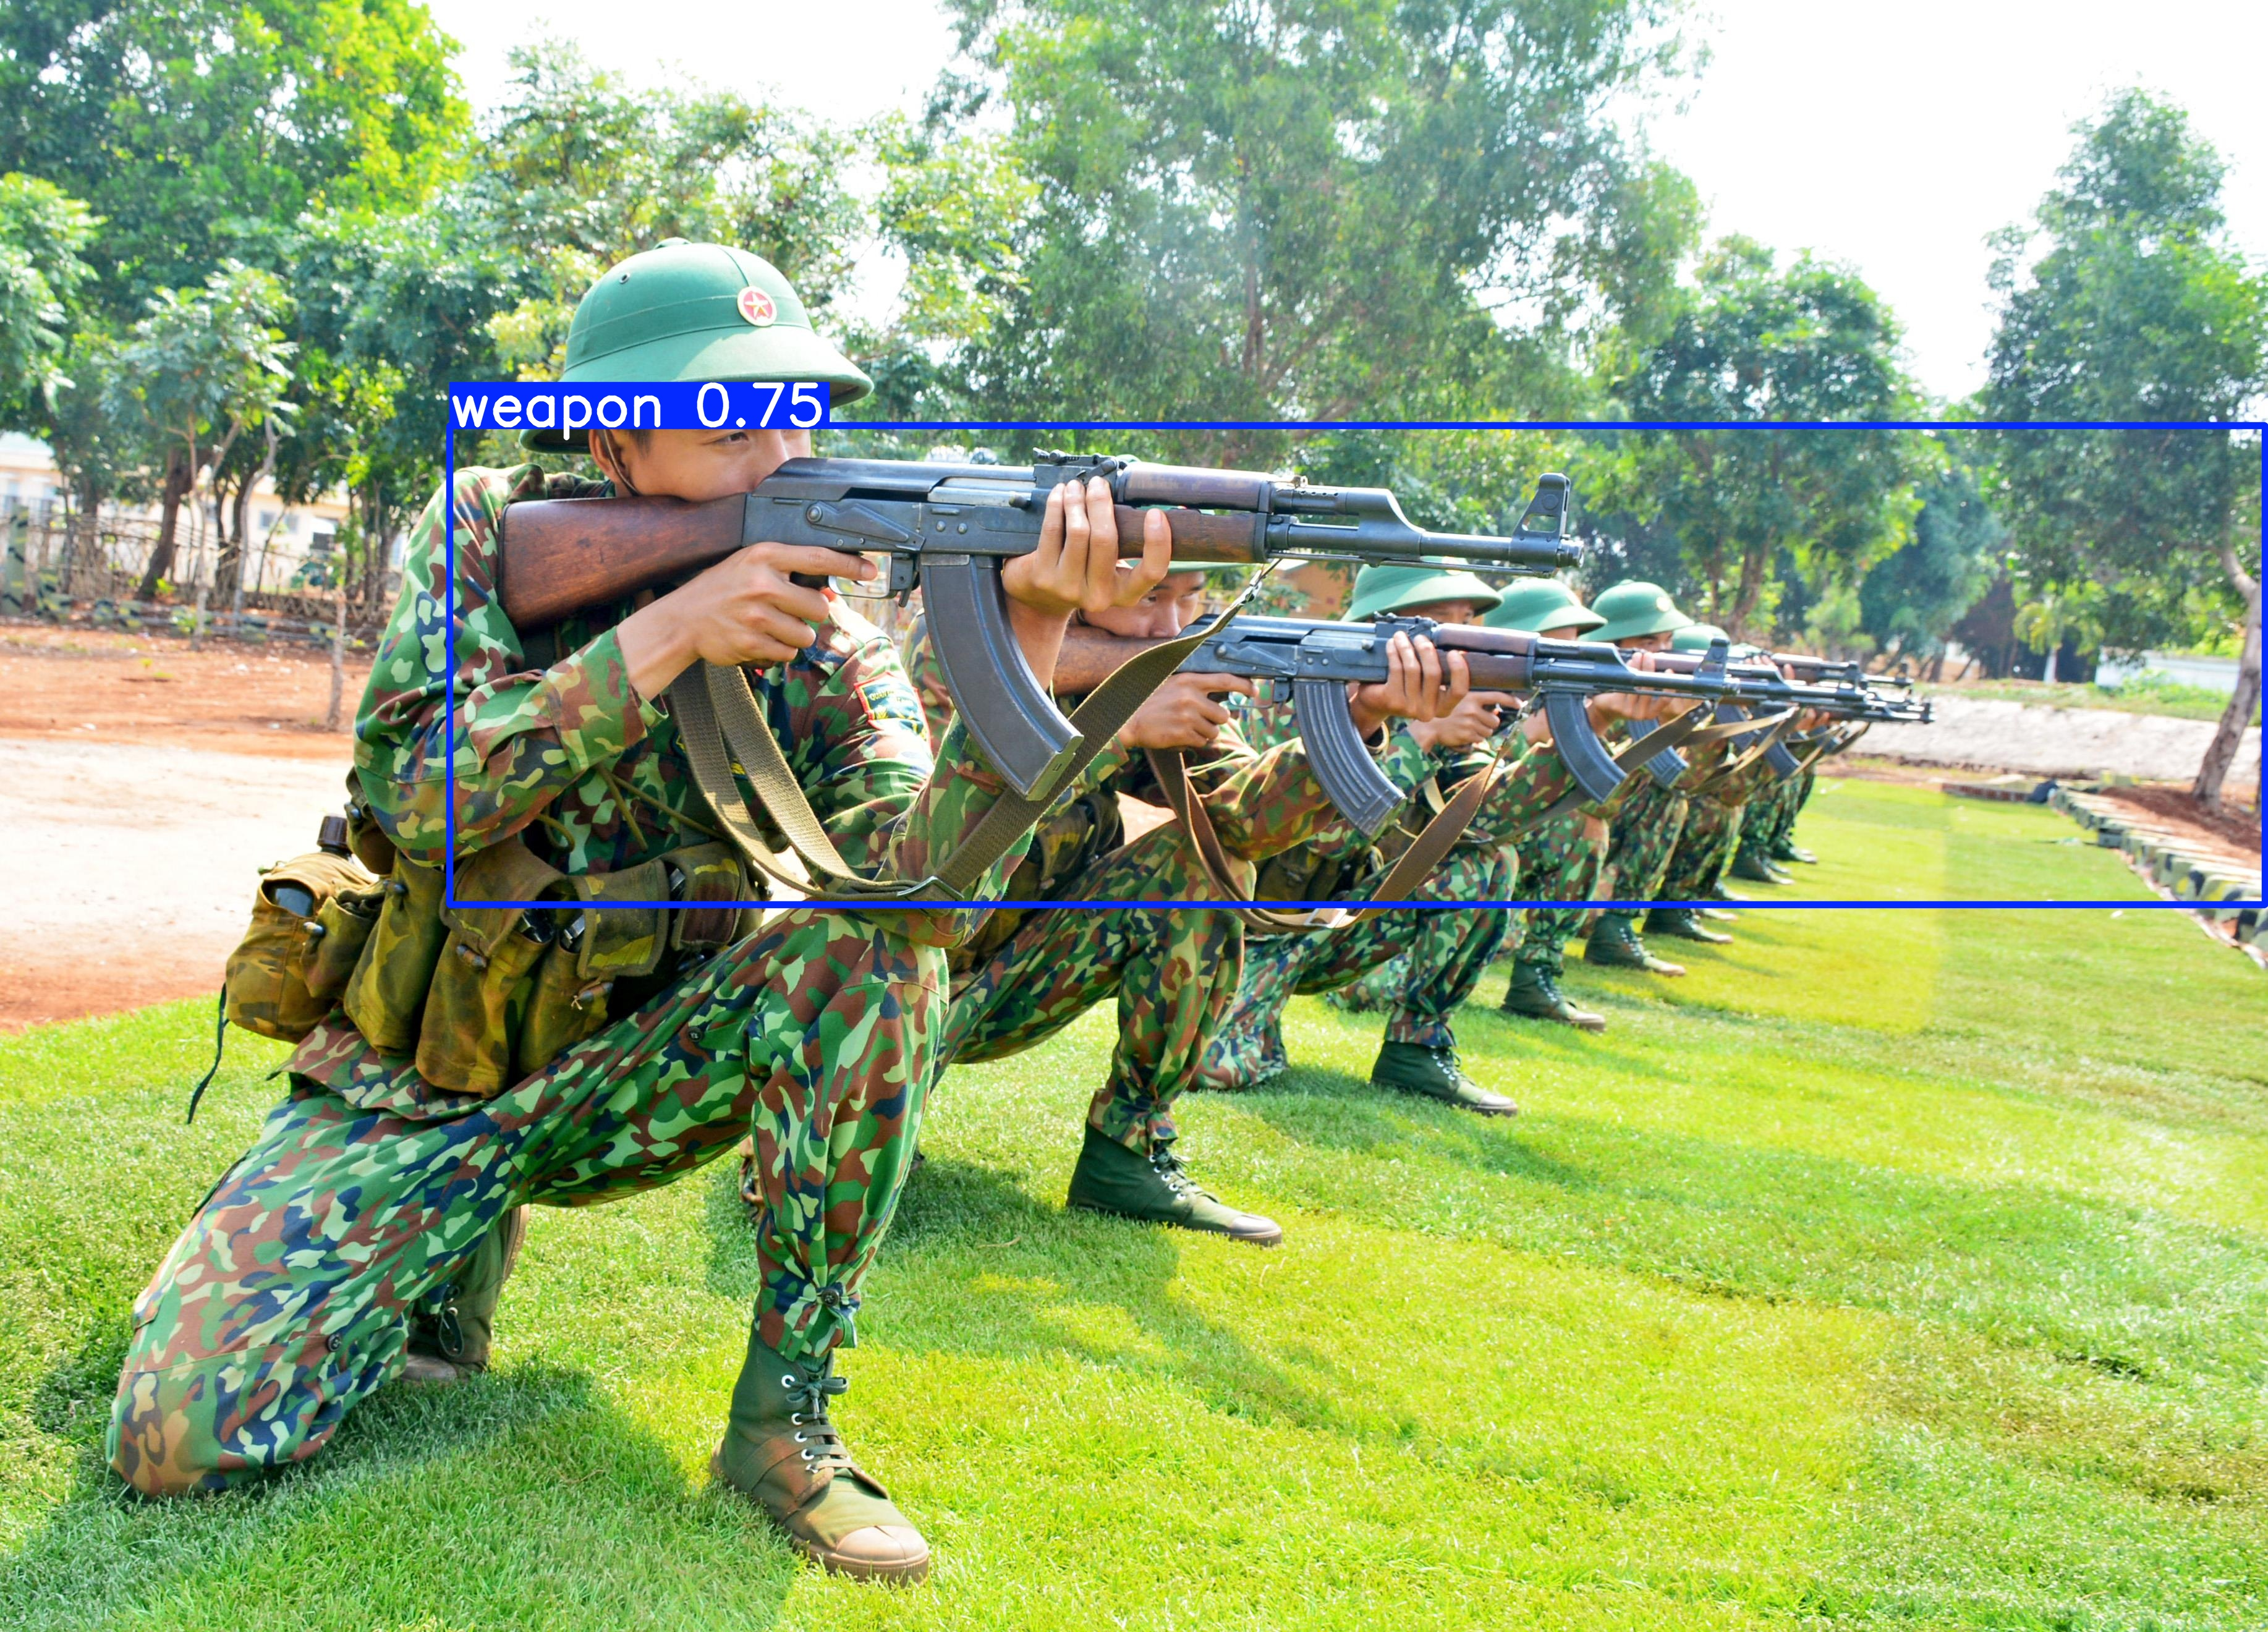

In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image

# Load model
model = YOLO("/content/best.pt")

# Chạy test trên 1 ảnh bất kỳ trong tập validation
# (Thay đường dẫn ảnh bên dưới bằng 1 ảnh thực tế trong folder valid/images)
results = model.predict(source="/content/anh-chu-bo-doi-dep_084318693.jpg", save=True)

# Hiển thị kết quả
display(Image(filename=results[0].save_dir + '/anh-chu-bo-doi-dep_084318693.jpg'))

In [ ]:
from ultralytics import YOLO


model = YOLO('/content/best.pt')

Chạy đánh giá trên tập validation
# data='/content/data.yaml': file cấu hình dataset bạn đã tạo lúc train
metrics = model.val(data='/content/data.yaml', split='val')

print(f"Precision (Độ chính xác): {metrics.box.mp:.3f}")
print(f"Recall (Độ nhạy): {metrics.box.mr:.3f}")
print(f"mAP50 (Điểm trung bình): {metrics.box.map50:.3f}")

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2743.1±1610.4 MB/s, size: 546.1 KB)
val: Scanning /content/datasets/weapon/weapon_detection/valid/labels.cache... 114 images, 0 backgrounds, 29 corrupt: 100% ━━━━━━━━━━━━ 114/114 47.8Mit/s 0.0s
val: /content/datasets/weapon/weapon_detection/valid/images/Automatic Rifle_25.jpeg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/datasets/weapon/weapon_detection/valid/images/SMG_21.jpeg: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/datasets/weapon/weapon_detection/valid/images/Sniper_10.jpeg: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/datasets/weapon/weapon_detectio